In [1]:
import sqlite3 as sq3
import pandas as pd
import seaborn as sns

In [2]:
con = sq3.connect('opioid.db')

In [3]:
population = pd.read_sql_query("SELECT * from population", con)
annual = pd.read_sql_query("SELECT * from annual", con)
land = pd.read_sql_query("SELECT * from land", con)

con.close()

In [4]:
annual_countyfips_NA = annual[(annual['countyfips'] == 'NA') & (annual['BUYER_STATE'] != 'PR')]


In [5]:
annual2 = annual.copy()
annual2.loc[((annual2['BUYER_STATE'] == 'AR') & (annual2['BUYER_COUNTY'] == 'MONTGOMERY')),'countyfips'] = '05097'

In [7]:
annual_noNA = annual2[annual2['BUYER_COUNTY'] != 'NA']

In [8]:
land_area = land[['Areaname','STCOU','LND110210D']]
land_area = land_area.rename(columns={'STCOU':'countyfips'})

In [9]:
county_info = pd.merge(population, land_area, how = 'left', on = 'countyfips')

In [10]:
annual['DOSAGE_UNIT'] = pd.to_numeric(annual['DOSAGE_UNIT']) 
pills_year = annual.groupby('year')['DOSAGE_UNIT'].mean().reset_index()
pills_year['Average_pills_in_millions'] = pills_year['DOSAGE_UNIT'] / 1000000

<Axes: xlabel='year', ylabel='Average_pills_in_millions'>

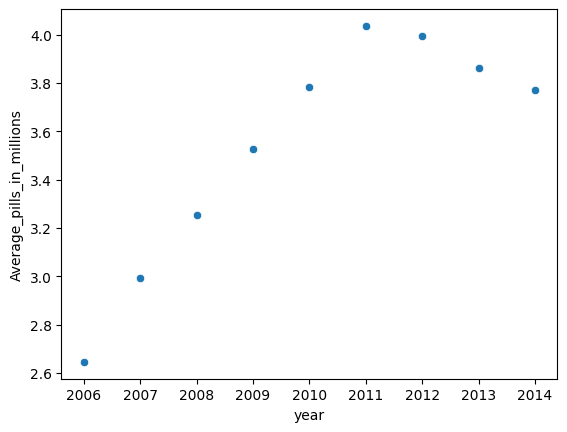

In [11]:
sns.scatterplot(x = 'year', y = 'Average_pills_in_millions', data = pills_year)

In [12]:
import rpy2
import rpy2.rinterface as ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

In [13]:
#rd = ro.packages.importr('readr')
dp = ro.packages.importr('dplyr')
base = ro.packages.importr('base')
td = ro.packages.importr('tidyr')

In [14]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()

with (ro.default_converter + pandas2ri.converter).context():
  populationr = ro.conversion.get_conversion().py2rpy(population)

with (ro.default_converter + pandas2ri.converter).context():
  annualr = ro.conversion.get_conversion().py2rpy(annual)

with (ro.default_converter + pandas2ri.converter).context():
  landr = ro.conversion.get_conversion().py2rpy(land)

In [105]:
#populationr = rd.read_csv("county_pop_arcos.csv")
#annualr = rd.read_csv("county_annual.csv")
#landr = rd.read_csv("land_area.csv")

In [15]:
annualr = td.replace_na(annualr, ro.ListVector({'countyfips': 'NA','BUYER_COUNTY': 'NA'}))

dp.filter(annualr, (annualr.rx2('BUYER_STATE') != 'PR') & (annualr.rx2('countyfips') == "NA"))


?,BUYER_COUNTY,BUYER_STATE,year,count,DOSAGE_UNIT,countyfips
...,...,...,...,...,...,...


In [16]:
annualr = dp.mutate(annualr,countyfips=base.ifelse((annualr.rx2('BUYER_STATE') == 'AR') & (annualr.rx2('BUYER_COUNTY') == 'MONTGOMERY'),'05097',annualr.rx2('countyfips')))

In [17]:
dp.filter(annualr,annualr.rx2('BUYER_COUNTY') != "NA")

?,BUYER_COUNTY,BUYER_STATE,year,count,DOSAGE_UNIT,countyfips
...,...,...,...,...,...,...


In [18]:
land_arear = dp.select(landr,ro.StrVector(['Areaname','STCOU','LND110210D']))
land_arear = dp.rename(land_arear, **{'countyfips': 'STCOU'})

In [19]:
county_infor = dp.left_join(populationr,land_arear,by = 'countyfips')

In [19]:
with (ro.default_converter + pandas2ri.converter).context():
  county_infor_pd = ro.conversion.get_conversion().rpy2py(county_infor)

county_infor_pd


,?,BUYER_COUNTY,BUYER_STATE,countyfips,STATE,COUNTY,county_name,NAME,variable,year,population,Areaname,LND110210D
1,1,AUTAUGA,AL,01001,1,1,Autauga,"Autauga County, Alabama",B01003_001,2006,51328,"Autauga, AL",594.44
2,2,BALDWIN,AL,01003,1,3,Baldwin,"Baldwin County, Alabama",B01003_001,2006,168121,"Baldwin, AL",1589.78
3,3,BARBOUR,AL,01005,1,5,Barbour,"Barbour County, Alabama",B01003_001,2006,27861,"Barbour, AL",884.88
4,4,BIBB,AL,01007,1,7,Bibb,"Bibb County, Alabama",B01003_001,2006,22099,"Bibb, AL",622.58
5,5,BLOUNT,AL,01009,1,9,Blount,"Blount County, Alabama",B01003_001,2006,55485,"Blount, AL",644.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28261,28261,WASHAKIE,WY,56043,56,43,Washakie,"Washakie County, Wyoming",B01003_001,2014,8444,"Washakie, WY",2238.55
28262,28262,WESTON,WY,56045,56,45,Weston,"Weston County, Wyoming",B01003_001,2014,7135,"Weston, WY",2398.09
28263,28263,SKAGWAY,AK,02230,2,230,Skagway,"Skagway Municipality, Alaska",B01003_001,2014,996,"Skagway, AK",452.33
28264,28264,HOONAH ANGOON,AK,02105,2,105,Hoonah Angoon,"Hoonah-Angoon Census Area, Alaska",B01003_001,2014,2126,"Hoonah-Angoon, AK",7524.92
